In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity.
What we will need:
- "imagenet_trained_model_weights.pkl"
- The betas and experiment stimuli
- A brain mask

In [2]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [3]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 4
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.10.0+cu113
cuda:  11.3
cudnn: 8200
dtype: torch.float32


In [4]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'anet_fwrf_nsdgeneral'
model_dir = '%s_%s' % (model_name, timestamp)

output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 

trn_subjects = [1,2,3,4,5,6,7,8]
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: Feb-02-2022_1002


# Load the stimuli images

In [5]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 2  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 3  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 4  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 5  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 6  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 7  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255
--------  subject 8  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


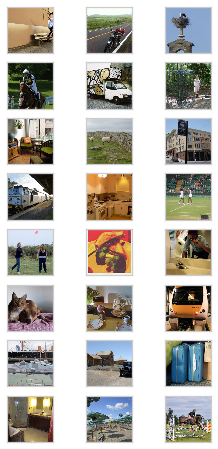

In [6]:
n = 1003
plt.figure(figsize=(4,1*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [7]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [8]:
beta_dir = '/export/raid1/home/surly/raid4/kendrick-data/nsd/nsddata_betas/ppdata/'

In [10]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    #voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ncsnr_full = load_mask_from_nii(beta_dir + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
        
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 11838
2396 	: V1
2071 	: V2
1667 	: V3
712 	: hV4
945 	: V3ab
474 	: LO
2148 	: IPS
480 	: VO
374 	: PHC
281 	: MT
54 	: MST
236 	: other
--------  subject 2  -------
(82, 106, 84)
full mask length = 730128
selection length = 10325
1630 	: V1
1523 	: V2
1565 	: V3
540 	: hV4
848 	: V3ab
503 	: LO
2196 	: IPS
431 	: VO
370 	: PHC
377 	: MT
35 	: MST
307 	: other
--------  subject 3  -------
(81, 106, 82)
full mask length = 704052
selection length = 11356
2273 	: V1
1753 	: V2
1460 	: V3
516 	: hV4
846 	: V3ab
528 	: LO
2302 	: IPS
496 	: VO
354 	: PHC
467 	: MT
62 	: MST
299 	: other
--------  subject 4  -------
(85, 99, 80)
full mask length = 673200
selection length = 9470
1509 	: V1
1321 	: V2
1183 	: V3
606 	: hV4
697 	: V3ab
416 	: LO
2263 	: IPS
479 	: VO
341 	: PHC
345 	: MT
39 	: MST
271 	: other
--------  subject 5  -------
(79, 97, 78)
full mask length = 597714
selection length = 9565
1699 	

## Display a slice of the data

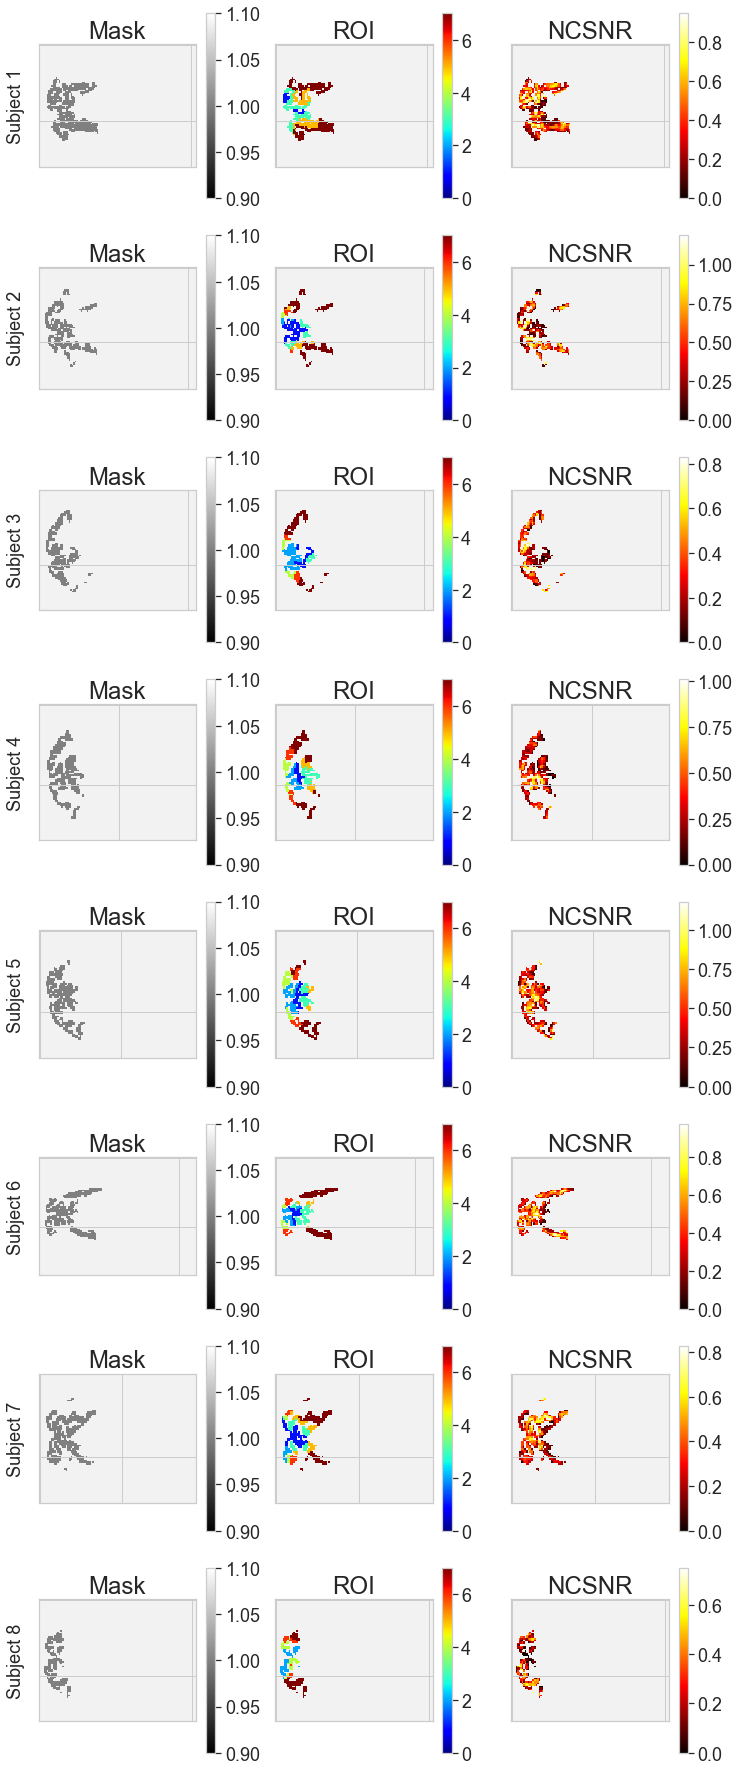

In [11]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    volume_ncsnr      = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+3)
    plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
    plt.title('NCSNR')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])

# Load voxels
## Quick load

In [12]:
#voxel_data_set = h5py.File(root_dir+'voxel_synth_data_V1-4_part1.h5py', 'r')
voxel_data_set = h5py.File(voxel_dir+'voxel_data_nsdgeneral_part1.h5py', 'r')
#voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part1.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = voxel_data_dict['voxel_data']

#voxel_data_set = h5py.File(root_dir+'voxel_synth_data_V1-4_part2.h5py', 'r')
voxel_data_set = h5py.File(voxel_dir+'voxel_data_nsdgeneral_part2.h5py', 'r')
#voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part2.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data.update(voxel_data_dict['voxel_data'])

voxel_data = {s: voxel_data['%d'%s] for s in voxel_roi.keys()}
print (voxel_data.keys())

dict_keys([1, 2, 3, 4, 5, 6, 7, 8])


## Slow load from raw data

In [15]:
## Long version
***
from src.load_nsd import load_betas

voxel_data = {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/"%s
    voxel_data[s],_ = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask[s], up_to=-1)
    print ('----------------------------')
    print (voxel_data[s].shape)
    
save_stuff(root_dir + 'voxel_data_general_part1', 
    flatten_dict({
   'voxel_mask': voxel_mask,
   'voxel_roi': voxel_roi,
   'voxel_idx': voxel_idx,
   'voxel_ncsnr': voxel_ncsnr,
   'voxel_data': voxel_data
            }))

--------  subject 3  -------
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj03/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat


KeyboardInterrupt: 

## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [13]:
from src.load_nsd import image_feature_fn, ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

stim_data = {}
data_size, nnv = {}, {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape      
    stim_data[s] = image_feature_fn(image_data[s])
    
    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)
    
del image_data
del voxel_data

--------  subject 1  -------
Total number of voxels = 11838
--------  subject 2  -------
Total number of voxels = 10325
--------  subject 3  -------
Total number of voxels = 11356
--------  subject 4  -------
Total number of voxels = 9470
--------  subject 5  -------
Total number of voxels = 9565
--------  subject 6  -------
Total number of voxels = 11827
--------  subject 7  -------
Total number of voxels = 9162
--------  subject 8  -------
Total number of voxels = 10178


In [15]:
trn_stim_mean = sum([np.mean(stim_data[s], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.47611815]]

  [[0.45324636]]

  [[0.41308543]]]]


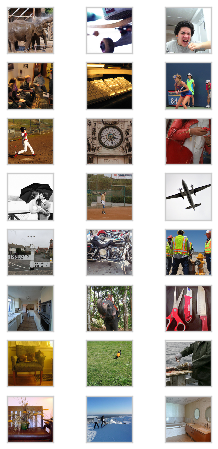

In [16]:
n = 1006
plt.figure(figsize=(4,1*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(stim_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

In [36]:
print ([len(m) for s,m in trn_stim_ordering.items()])

[27000, 27000, 21629, 20312, 27000, 21629, 27000, 20312]


---
# Load Model

In [37]:
def get_value(_x):
    return np.copy(_x.data.cpu().numpy())
def set_value(_x, x):
    _x.data.copy_(T.from_numpy(x))
def subject_pred_pass(s, x, v, batch_size):
    pred = get_predictions(x, _fmaps_fn, _fwrf_fn, best_params[s], sample_batch_size=batch_size)
    return pred
def validation_fn(s, xb):
    _,r,_ = model_fn(s, T.from_numpy(xb).to(device))
    return r
def subject_validation_pass(s, x, v, batch_size):
    val_cc  = np.zeros(shape=(v.shape[1]), dtype=v.dtype)
    val_pred = subject_pred_pass(s, x, v, batch_size)
    for i in range(v.shape[1]):
        val_cc[i] = np.corrcoef(v[:,i], val_pred[:,i])[0,1]                  
    return val_cc
def learn_params_(_fmaps_fn, stims, voxels, ordering, sample_batch_size, voxel_batch_size, holdout_frac, lambdas, aperture, nl=None, trn_size=None, randomize=False):
    from src.torch_fwrf import  learn_params_ridge_regression, get_predictions, Torch_fwRF_voxel_block
    best_losses, best_lambdas, best_params, trn_index, hld_index = {}, {}, {}, {}, {}
    for k,s in enumerate(voxels.keys()):
        if trn_size is None:
            ts = len(ordering[s])
        else:
            ts = min(trn_size, len(ordering[s]))
        index = np.arange(len(ordering[s]))
        if randomize:
            np.random.shuffle(index)
        holdout_size = int(np.ceil(ts * holdout_frac))
        trn_actual = ts - holdout_size
        trn_index[s] = index[:ts][:trn_actual] # this is recalculated in learn_params_ridge_regression. The regression routine just didn't return the indices.
        hld_index[s] = index[:ts][trn_actual:]
        ###
        best_losses[s], best_lambdas[s], best_params[s] = learn_params_ridge_regression(
            stims[s][ordering[s][index[:ts]]], voxels[s][index[:ts]], _fmaps_fn, models, lambdas, \
            aperture=aperture, _nonlinearity=nl, zscore=True, sample_batch_size=sample_batch_size, \
            voxel_batch_size=voxel_batch_size, holdout_size=holdout_size, shuffle=False, add_bias=True)
    ###
    return best_params, best_losses, best_lambdas, trn_index, hld_index
def validation_(stims, voxels, batch_size):
    subject_val_cc = {}
    #shared_model.eval()
    for s in voxels.keys():          
        val_cc = subject_validation_pass(s, stims[s], voxels[s], batch_size) 
        subject_val_cc[s] = np.nan_to_num(val_cc)    
    return subject_val_cc
def sample_with_replacement(indices):
    return indices[np.random.randint(len(indices), size=len(indices))]    
def cc_resampling_with_replacement(s, x, v, batch_size, n_resample=1):
    pred = subject_pred_pass(s, x, v, batch_size)
    cc = np.zeros(shape=(v.shape[1]), dtype=fpX)
    ccs = []
    for rs in tqdm(range(n_resample)):
        res = sample_with_replacement(np.arange(len(pred)))
        data_res = v[res]
        pred_res = pred[res]
        for i in range(data_res.shape[1]):
            cc[i] = np.corrcoef(data_res[:,i], pred_res[:,i])[0,1]  
        ccs += [np.nan_to_num(cc)]
    return ccs

In [18]:
from models.alexnet import Alexnet_fmaps
from src.torch_fwrf import Torch_fwRF_voxel_block
_fmaps_fn = Alexnet_fmaps(pretrained=True).to(device)

In [20]:
_x = torch.tensor(stim_data[trn_subjects[0]][:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 64, 27, 27])
torch.Size([100, 192, 27, 27])
torch.Size([100, 384, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 256, 13, 13])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 4096, 1, 1])
torch.Size([100, 1000, 1, 1])


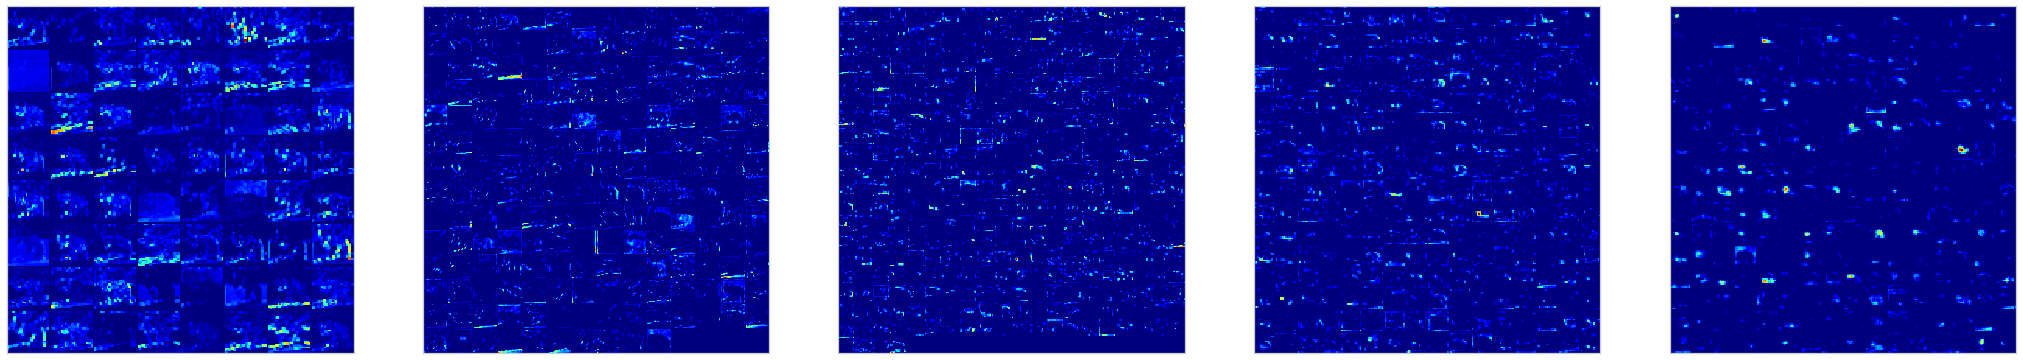

In [21]:
plt.figure(figsize=(36,12))
for k,_fm in enumerate(_fmaps[:5]):
    plt.subplot(1,5,k+1)
    plt.imshow(pnu.mosaic_vis(get_value(_fm)[8], pad=1), interpolation='None', cmap='jet')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)  

In [22]:
from src.torch_feature_space import filter_dnn_feature_maps

fmap_max = 512
# I used image_data because the repeats are not relevant
_fmaps_fn, lmask, fmask, tuning_masks = \
    filter_dnn_feature_maps(np.concatenate([d for s,d in stim_data.items()], axis=0), _fmaps_fn, batch_size=100, fmap_max=fmap_max)

800it [00:56, 14.17it/s]

layer: 0, shape=(100, 64, 27, 27)
layer: 1, shape=(100, 192, 27, 27)
layer: 2, shape=(100, 384, 13, 13)
layer: 3, shape=(100, 256, 13, 13)
layer: 4, shape=(100, 256, 13, 13)
layer: 5, shape=(100, 512, 1, 1)
layer: 6, shape=(100, 512, 1, 1)
layer: 7, shape=(100, 512, 1, 1)

fmaps: 0, shape=(100, 256, 27, 27)
fmaps: 1, shape=(100, 896, 13, 13)
fmaps: 2, shape=(100, 1536, 1, 1)


In [24]:
filters = {
            'fmap_max': fmap_max,
            'lmask': lmask,
            'fmask': fmask,
            'tuning_masks': tuning_masks
        }

torch.save(filters, root_dir+'output/alexnet_model_filters_512')

In [26]:
_x = torch.tensor(stim_data[trn_subjects[0]][:100]).to(device) # the input variable.
_fmaps = _fmaps_fn(_x)
for k,_fm in enumerate(_fmaps):
    print (_fm.size())

torch.Size([100, 256, 27, 27])
torch.Size([100, 896, 13, 13])
torch.Size([100, 1536, 1, 1])


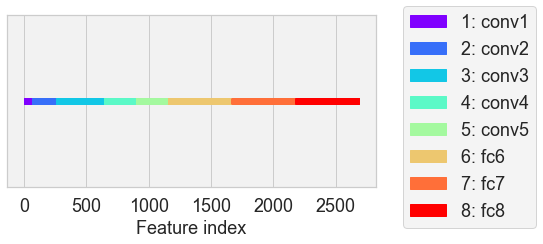

In [30]:
from matplotlib import cm
from matplotlib.patches import Patch

cmap = [cm.get_cmap('rainbow', len(tuning_masks))(k) for k in range(len(tuning_masks))]

layer_names = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7', 'fc8']
fig=plt.figure(figsize=(8, 4))
plt.subplots_adjust(left=0.01, bottom=0.35, right=.65, top=.95, wspace=0.16, hspace=0.)
legend_elements = [Patch(facecolor=cmap[k], edgecolor=cmap[k], label='%d: %s'%(k+1, layer_names[k])) for k,tm in enumerate(tuning_masks)]
for k,tm in enumerate(tuning_masks):
    _=plt.plot(tm, marker='|', linestyle='None', color=cmap[k])
#_=plt.title('Feature index layer correspondence')
_=plt.xlabel('Feature index')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1.1))

In [31]:
from src.rf_grid    import linspace, logspace, model_space, model_space_pyramid
from src.torch_fwrf import learn_params_ridge_regression, get_predictions

aperture = np.float32(1)
nx = ny = 11
smin, smax = np.float32(0.03), np.float32(0.4)
ns = 8

# sharedModel specification is a list of 3 ranges and 3 callable functor. The reason for this is for a future implementation of dynamic mesh refinement.
#model_specs = [[(0., aperture*1.1), (0., aperture*1.1), (smin, smax)], [linspace(nx), linspace(ny), logspace(ns)]]
#models = model_space(model_specs)
models = model_space_pyramid(logspace(ns)(smin, smax), min_spacing=1., aperture=1.1*aperture)
print ('candidate count = ', len(models))

#_log_act_func = lambda _x: torch.log(1 + torch.abs(_x))

candidate count =  2680


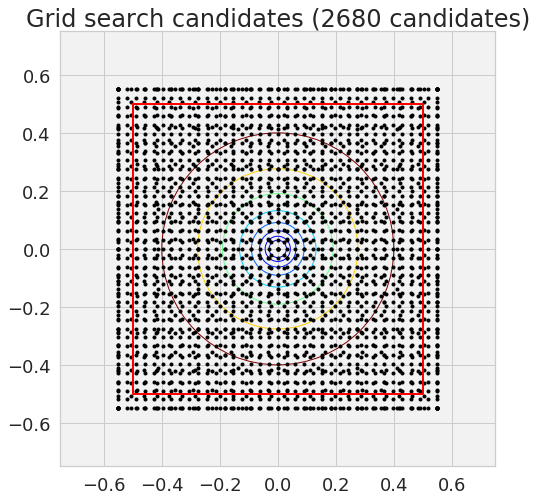

In [32]:
from matplotlib.patches import Ellipse
import matplotlib.colors as colors
import matplotlib.cm as cmx

lx, vx = aperture, aperture * 1.5
cNorm  = colors.Normalize(vmin=.0, vmax=.4)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=plt.get_cmap('jet') )

plt.figure(figsize=(8, 8))
plt.title('Grid search candidates (%d candidates)' % len(models))
plt.plot(models[:,0], models[:,1], '.k', linestyle='None')
ax = plt.gca()
for s in np.unique(models[:,2]):
    ax.add_artist(Ellipse(xy=(0,0), width=2*s, height=2*s, angle=0,
        color=scalarMap.to_rgba(s), lw=1, fill=False))
_=ax.set_xlim(-vx/2, vx/2)
_=ax.set_ylim(-vx/2, vx/2)
_=ax.set_aspect('equal')
plt.plot([-lx/2,lx/2,lx/2,-lx/2,-lx/2], [lx/2,lx/2,-lx/2,-lx/2, lx/2], 'r', lw=2)

## Training

In [39]:
sample_batch_size = 100
voxel_batch_size = 500
holdout_frac = 0.1
lambdas = np.logspace(3.,6.,9, dtype=np.float32)

best_params, best_losses, best_lambdas, trn_index, hld_index = \
    learn_params_(_fmaps_fn, stim_data, trn_voxel_data, trn_stim_ordering, sample_batch_size, voxel_batch_size, holdout_frac, lambdas, aperture, nl=None, trn_size=None, randomize=False)

trn_size = 24300 (90.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([100, 256, 27, 27])
torch.Size([100, 896, 13, 13])
torch.Size([100, 1536, 1, 1])
---------------------------------------

model 2679 of 2680, voxels [ 11500:11837 ] of 11838
---------------------------------------
total time = 16849.768943s
total throughput = 1.423363s/voxel
voxel throughput = 0.250576s/voxel
setup throughput = 5.180393s/model
trn_size = 24300 (90.0%)
dtype = <class 'numpy.float32'>
device = cuda:0
---------------------------------------
torch.Size([100, 256, 27, 27])
torch.Size([100, 896, 13, 13])
torch.Size([100, 1536, 1, 1])
---------------------------------------

model 2679 of 2680, voxels [ 10000:10324 ] of 10325
---------------------------------------
total time = 15836.989244s
total throughput = 1.533849s/voxel
voxel throughput = 0.270907s/voxel
setup throughput = 4.865626s/model
trn_size = 19466 (90.0%)
dtype = <class 'numpy.float32'>
dev

In [40]:
print ([p.shape if p is not None else None for p in best_params[trn_subjects[0]]])

[(11838, 3), (11838, 2688), (11838,), (11838, 2688), (11838, 2688)]


Text(0, 0.5, 'Count')

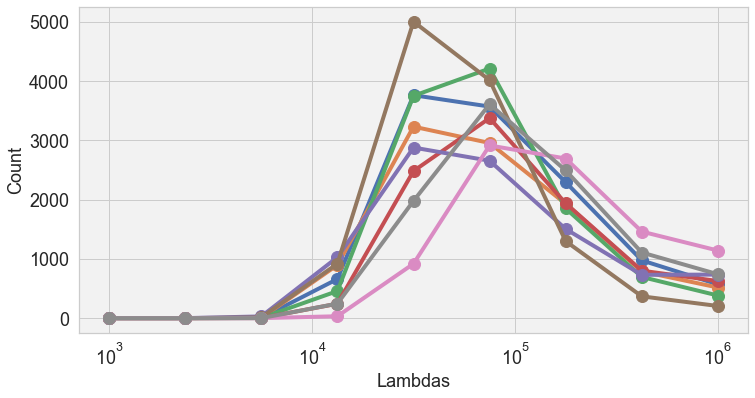

In [41]:
fig=plt.figure(figsize=(12,6))
for s,bl in best_lambdas.items():
    plt.plot(lambdas, [np.sum(bl==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log')
plt.xlabel('Lambdas')
plt.ylabel('Count')

# Holdout validation
This is just so that we can calculate a validation score on the set of images used for holdout -- to compare with the same metric as was used for early stopping with gnet. Here there is no other need for this.

In [44]:
from src.torch_fwrf import Torch_fwRF_voxel_block
sample_batch_size = 200

param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params[list(best_params.keys())[0]]]
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=_log_act_func, input_shape=stim_data[list(stim_data.keys())[0]].shape, aperture=1.0)

subject_hld_cc = validation_({s: stim[order[m]] for s,stim,order,m in zip_dict(stim_data, trn_stim_ordering, hld_index)}, \
                             {s: vox[m] for s,vox,m in zip_dict(trn_voxel_data, hld_index)}, sample_batch_size)
joined_hld_cc = np.concatenate(list(subject_hld_cc.values()), axis=0)

samples [24200:24299] of 24300, voxels [  2500:2999  ] of 11838

KeyboardInterrupt: 

In [ ]:
#print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_hld_cc))
for s,v in subject_hld_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_hld_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

## Validation

In [45]:
from src.torch_fwrf import Torch_fwRF_voxel_block
sample_batch_size = 200

param_batch = [p[:voxel_batch_size] if p is not None else None for p in best_params[list(best_params.keys())[0]]]
_fwrf_fn = Torch_fwRF_voxel_block(_fmaps_fn, param_batch, _nonlinearity=_log_act_func, input_shape=stim_data[list(stim_data.keys())[0]].shape, aperture=1.0)

subject_val_cc = validation_({s: stim[order] for s,stim,order in zip_dict(stim_data, val_stim_ordering)}, val_voxel_data, sample_batch_size)
joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

samples [ 2800:2999 ] of 3000, voxels [ 11500:11837 ] of 11838
---------------------------------------
total time = 149.879260s
sample throughput = 0.049960s/sample
voxel throughput = 0.012661s/voxel
samples [ 2800:2999 ] of 3000, voxels [ 10000:10324 ] of 10325
---------------------------------------
total time = 124.422871s
sample throughput = 0.041474s/sample
voxel throughput = 0.012051s/voxel
samples [ 2200:2370 ] of 2371, voxels [ 11000:11355 ] of 11356
---------------------------------------
total time = 138.595662s
sample throughput = 0.058455s/sample
voxel throughput = 0.012205s/voxel
samples [ 2000:2187 ] of 2188, voxels [  9000:9469  ] of 9470
---------------------------------------
total time = 109.973009s
sample throughput = 0.050262s/sample
voxel throughput = 0.011613s/voxel
samples [ 2800:2999 ] of 3000, voxels [  9500:9564  ] of 9565
---------------------------------------
total time = 98.708586s
sample throughput = 0.032903s/sample
voxel throughput = 0.010320s/voxel
sam

best joint val cc = 0.179
subject 1: val cc = 0.220
subject 2: val cc = 0.207
subject 3: val cc = 0.178
subject 4: val cc = 0.163
subject 5: val cc = 0.240
subject 6: val cc = 0.195
subject 7: val cc = 0.147
subject 8: val cc = 0.101


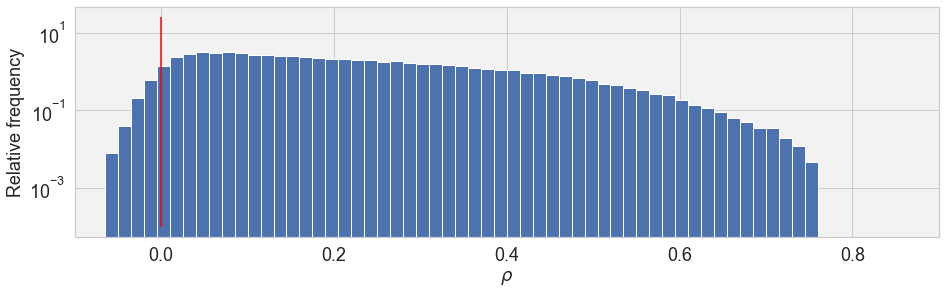

In [46]:
#print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_val_cc))
for s,v in subject_val_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

# Save results to file

In [47]:
torch.save({
            'subjects': trn_subjects,
            'sample_batch_size': sample_batch_size,
            'voxel_batch_size': voxel_batch_size,
            'holdout_frac': holdout_frac,  
            'lmask': lmask,
            'fmask': fmask,
            'tuning_masks': tuning_masks,
            'best_params': best_params, 
            'val_cc': subject_val_cc,
            'brain_nii_shape': brain_nii_shape,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask
            },output_dir+'model_params')